In [1]:
import os
import pandas as pd
import yaml

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns

sns.set_theme()

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\824543525.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
root_dir = r".\results\2024Apr07-010207_configs"

In [3]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record_combined.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                try:
                    with open(cfg_path, "r") as cfg_file:
                        cfg_data = yaml.safe_load(cfg_file)
                except FileNotFoundError:
                    print(f"Configuration file not found for {file_path}. Skipping...")
                    continue

                # Extract needed parameters, handle missing data gracefully
                run_id = cfg_data.get(
                    "run_id", "unknown"
                )  # Provide default values if key is missing
                tau = cfg_data.get("tau", 0)  # Default value if missing
                min_samples = cfg_data.get("min_samples", 0)  # Default value if missing

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame if not empty, otherwise return an empty DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

,run_id,tau,min_samples,epoch
0,0,0.001,20,299
1,0,0.010,20,299
2,0,0.100,20,299
3,0,1.000,20,299
4,0,10.000,20,299
5,1,0.001,20,299
6,1,0.010,20,299
7,1,0.100,20,299
8,1,1.000,20,299
9,1,10.000,20,299


In [23]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))

def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {str(loader.construct_object(key)): loader.construct_object(value) for key, value in node.value}
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)

yaml.SafeLoader.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)
yaml.SafeLoader.add_multi_constructor('', generic_constructor)

def collect_bellman_errors(root_dir):
    all_errors = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith("bellman_error_combined.csv"):
                file_path = os.path.join(subdir, file)
                df_errors = pd.read_csv(file_path)

                cfg_path = os.path.join(subdir, "post_cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                for param, value in cfg_data.items():
                    if isinstance(value, dict):
                        for sub_param, sub_value in value.items():
                            df_errors[f"{param}_{sub_param}"] = sub_value
                    else:
                        df_errors[param] = value

                all_errors.append(df_errors)

    if all_errors:
        return pd.concat(all_errors)
    else:
        raise ValueError("No CSV files found in the specified directory.")
    

# Example usage (assuming `root_dir` is defined)
bellman_errors_df = collect_bellman_errors(root_dir)

bellman_errors_df

,model,bellman_error,alpha,batch_size,cfg_id,cols,epsilon,experiment,experiment_arguments_min_samples,experiment_arguments_tau,...,out_dir,p_success,rows,run_id,seed,start_state,tau,"terminal_states_(8, 8)",title,train_max_iterations
0,qnet_original,4.045330e-01,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,.\results\2024Apr07-010207_configs\0000_tau_0....,1,10,0,2501825851,1,0.001,1.0,tau=0.001; min_samples=20,300
1,qnet_adjusted_loss,1.671899e-01,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,.\results\2024Apr07-010207_configs\0000_tau_0....,1,10,0,2501825851,1,0.001,1.0,tau=0.001; min_samples=20,300
0,qnet_original,5.200095e+10,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,.\results\2024Apr07-010207_configs\0000_tau_0....,1,10,1,1548086781,1,0.001,1.0,tau=0.001; min_samples=20,300
1,qnet_adjusted_loss,6.070817e+10,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,.\results\2024Apr07-010207_configs\0000_tau_0....,1,10,1,1548086781,1,0.001,1.0,tau=0.001; min_samples=20,300
0,qnet_original,1.940776e-02,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,.\results\2024Apr07-010207_configs\0000_tau_0....,1,10,2,3307717503,1,0.001,1.0,tau=0.001; min_samples=20,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,qnet_adjusted_loss,1.066971e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,.\results\2024Apr07-010207_configs\0004_tau_10...,1,10,7,904601737,1,10.000,1.0,tau=10; min_samples=20,300
0,qnet_original,1.856412e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,.\results\2024Apr07-010207_configs\0004_tau_10...,1,10,8,3666975029,1,10.000,1.0,tau=10; min_samples=20,300
1,qnet_adjusted_loss,1.797133e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,.\results\2024Apr07-010207_configs\0004_tau_10...,1,10,8,3666975029,1,10.000,1.0,tau=10; min_samples=20,300
0,qnet_original,1.093119e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,.\results\2024Apr07-010207_configs\0004_tau_10...,1,10,9,874601122,1,10.000,1.0,tau=10; min_samples=20,300


In [24]:
bellman_errors_df["seed"]

0    2501825851
1    2501825851
0    1548086781
1    1548086781
0    3307717503
        ...    
1     904601737
0    3666975029
1    3666975029
0     874601122
1     874601122
Name: seed, Length: 100, dtype: int64

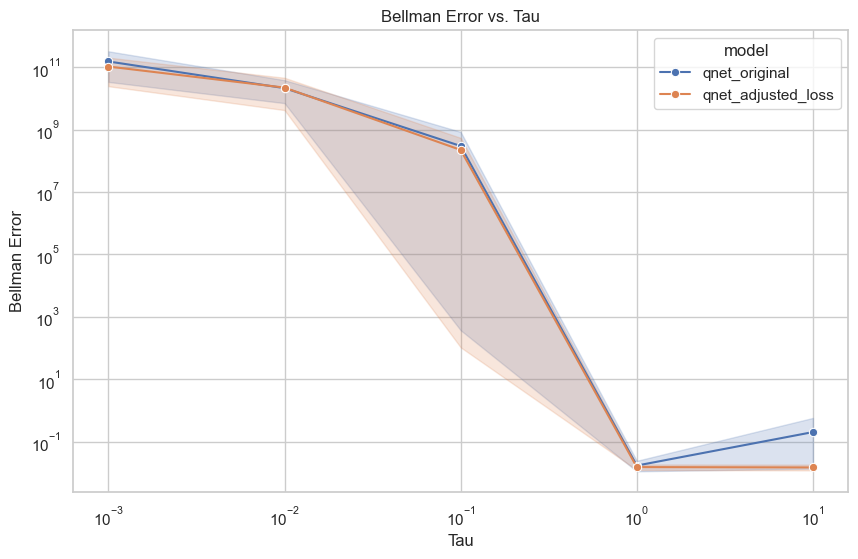

In [11]:

plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(data=bellman_errors_df, x="tau", y="bellman_error", 
             hue="model",
             marker="o", errorbar="ci")


# Adjustments to plot aesthetics
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")

plt.show()



In [26]:
bellman_errors_df.iloc[0]

model                                                                   qnet_original
bellman_error                                                                0.404533
alpha                                                                             0.1
batch_size                                                                         32
cfg_id                                                                              0
cols                                                                               10
epsilon                                                                          0.01
experiment                                                   experiment_distributions
experiment_arguments_min_samples                                                   20
experiment_arguments_tau                                                        0.001
full_title                          2024Apr07-010207_configs_tau=0.001; min_sample...
gamma                                                 

In [29]:
# With access to seeds, check why some examles have much lower bellman errors:

from experiment_src import (
    train_net_with_value_function_approximation,
    generate_random_policy_transitions,
    generate_transitions_observations,
    generate_train_test_split_with_valid_path,
    make_env
)
from experiments.experiment_utils import setup_logger, seed_everything

seed = 3
start_state = (0, 0)
terminal_states = {(8, 8): 1}
rows = 10
cols = 10
p_success = 1.0
num_steps = 40_000
tau = 10

def experiment_sample(seed, start_state, terminal_states, rows, cols, p_success, num_steps, tau):
    seed_everything(seed)
    np.random.seed(seed)

    env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

    states = list(set([s for s, _ in env.mdp.keys()]))
    actions = list(set([a for _, a in env.mdp.keys()]))

    transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

    transitions_train, transitions_val = generate_train_test_split_with_valid_path(
        transitions_list=transitions_list,
        start_state=start_state,
        terminal_states=terminal_states,
    )

    train_dataset_transitions = generate_transitions_observations(
        transitions_train, num_steps, tau, min_samples=0
    )
    
    return train_dataset_transitions

samples = experiment_sample(seed, start_state, terminal_states, rows, cols, p_success, num_steps, tau)

In [49]:
def sum_rewards(transitions):
    return sum(transition[3] for transition in transitions)

def count_transitions_terminal(transitions, target_value=1.0):
    transition_counts = {}
    for transition in transitions:
        if transition[3] == target_value:
            key = tuple(transition[:3])
            transition_counts[key] = transition_counts.get(key, 0) + 1
    return transition_counts

def count_transitions(transitions, target_value=1.0):
    transition_counts = {}
    for transition in transitions:
        key = tuple(transition[:3])
        transition_counts[key] = transition_counts.get(key, 0) + 1
    return transition_counts

sum_rewards(samples)
t_counts = count_transitions_terminal(samples)
t_counts

{((7, 8), <Action.DOWN: 2>, (8, 8)): 140,
 ((8, 9), <Action.LEFT: 3>, (8, 8)): 126,
 ((9, 8), <Action.UP: 0>, (8, 8)): 112}

In [50]:
def process_row(row):
  
    terminal_states = {(8, 8): 1.0}  
    start_state = (1, 1)
    train_dataset_transitions = experiment_sample(
        seed=row['seed'],
        start_state=start_state,
        terminal_states=terminal_states,
        rows=row['rows'],
        cols=row['cols'],
        p_success=row['p_success'],
        num_steps=row['num_steps'],
        tau=row['tau']
    )
    
    sum_of_rewards = sum_rewards(train_dataset_transitions)
    terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
    transition_counts = count_transitions(train_dataset_transitions)
    
    # Assuming the count_transitions function returns a count you want directly; if it's more complex, adjust accordingly.
    return pd.Series([sum_of_rewards, len(terminal_t_counts),len(transition_counts)], index=['sum_rewards', 'distinct_terminal_states', 'distinct_transitions'])

results_df = bellman_errors_df.apply(process_row, axis=1)

# Concatenate the new results with the original DataFrame
df_with_results = pd.concat([bellman_errors_df, results_df], axis=1)
df_with_results


,model,bellman_error,alpha,batch_size,cfg_id,cols,epsilon,experiment,experiment_arguments_min_samples,experiment_arguments_tau,...,run_id,seed,start_state,tau,"terminal_states_(8, 8)",title,train_max_iterations,sum_rewards,distinct_terminal_states,distinct_transitions
0,qnet_original,4.045330e-01,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,0,2501825851,1,0.001,1.0,tau=0.001; min_samples=20,300,0.0,0.0,2.0
1,qnet_adjusted_loss,1.671899e-01,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,0,2501825851,1,0.001,1.0,tau=0.001; min_samples=20,300,0.0,0.0,2.0
0,qnet_original,5.200095e+10,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,1,1548086781,1,0.001,1.0,tau=0.001; min_samples=20,300,0.0,0.0,8.0
1,qnet_adjusted_loss,6.070817e+10,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,1,1548086781,1,0.001,1.0,tau=0.001; min_samples=20,300,0.0,0.0,8.0
0,qnet_original,1.940776e-02,0.1,32,0,10,0.01,experiment_distributions,20,0.001,...,2,3307717503,1,0.001,1.0,tau=0.001; min_samples=20,300,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,qnet_adjusted_loss,1.066971e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,7,904601737,1,10.000,1.0,tau=10; min_samples=20,300,283.0,2.0,316.0
0,qnet_original,1.856412e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,8,3666975029,1,10.000,1.0,tau=10; min_samples=20,300,362.0,3.0,316.0
1,qnet_adjusted_loss,1.797133e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,8,3666975029,1,10.000,1.0,tau=10; min_samples=20,300,362.0,3.0,316.0
0,qnet_original,1.093119e-02,0.1,32,4,10,0.01,experiment_distributions,20,10.000,...,9,874601122,1,10.000,1.0,tau=10; min_samples=20,300,416.0,3.0,316.0


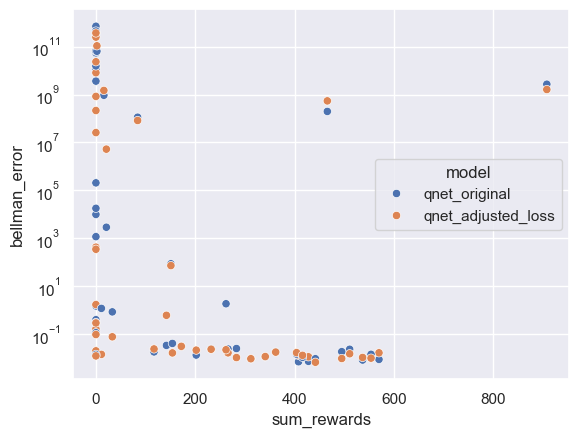

In [51]:
sns.scatterplot(data=df_with_results, x="sum_rewards", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

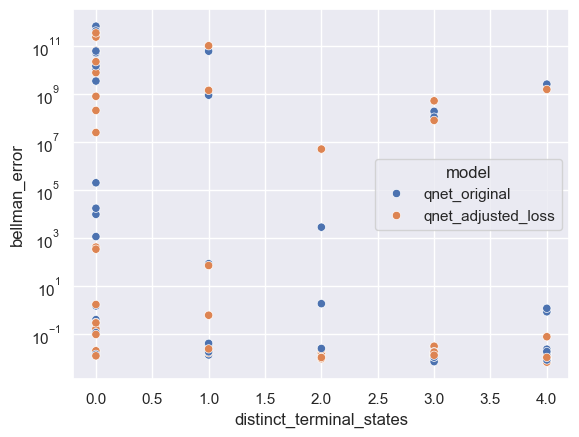

In [54]:
sns.scatterplot(data=df_with_results, x="distinct_terminal_states", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

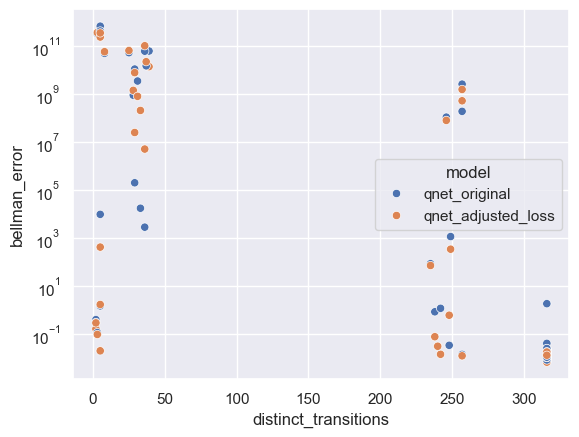

In [55]:
sns.scatterplot(data=df_with_results, x="distinct_transitions", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\2157596148.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\2157596148.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


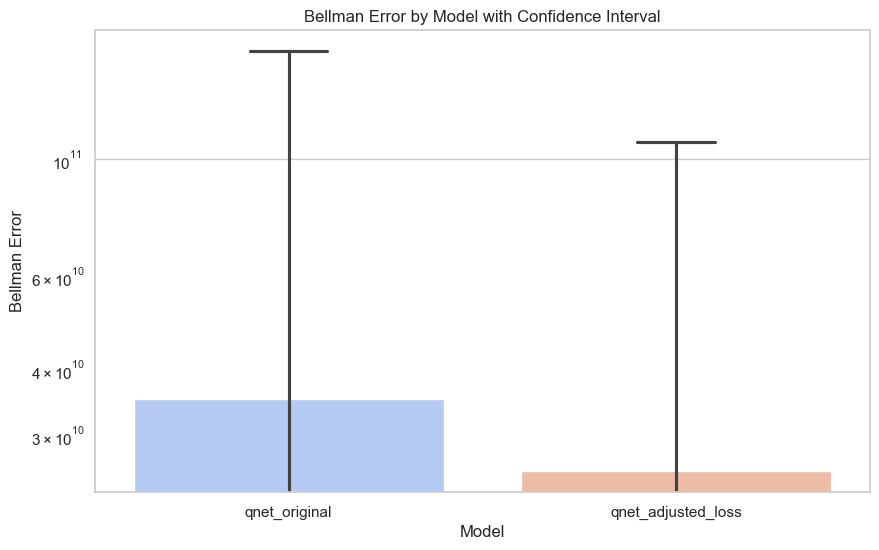

In [6]:
# Assuming your DataFrame is named df
sns.set_theme(style="whitegrid")  # Setting the theme for the plots

plt.figure(figsize=(10, 6))  # Setting the figure size
ax = sns.barplot(
    x="model",
    y="bellman_error",
    data=bellman_errors_df,
    ci="sd",
    palette="coolwarm",
    capsize=0.2,
)

plt.title("Bellman Error by Model with Confidence Interval")
plt.ylabel("Bellman Error")
plt.xlabel("Model")
plt.yscale(
    "log"
)  # Optional: use logarithmic scale for better visualization of wide value ranges

plt.show()